# レスラー方程式のサブシステムの予測（外力あり）．

In [167]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


In [168]:
#def reset_esn()の定義
#reset_esn()は一体何に使うのか？

def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

In [169]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

# 位相シフトの関数を定義します。
def phase_shift(t):
    shift_value = (8/24)*2*np.pi
    number_of_shifts = int(t / (4*2*np.pi))
    return number_of_shifts * shift_value

# 外力の関数を定義します。
def external_force(t, D, omega):
    return D * np.sin(omega * t + phase_shift(t))

# 外力が加わるレスラー方程式を定義します。
def rossler_with_force(t, state, a, b, c, D, omega):
    x, y, z = state
    dxdt = -y - z + external_force(t, D, omega)  # x成分に外力項を追加
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]


# パラメータと初期状態を設定します。
a, b, c = 0.2, 0.2, 5.7
D = 2.0  # 外力の振幅
omega = 1.0  # 外力の角周波数
initial_state = [1.0, 1.0, 1.0]

# 時間範囲を設定します。
t_span = (0, 250)
t_eval = np.linspace(t_span[0], t_span[1], 25000)

# 外力が加わるレスラー方程式を解きます。
solution = solve_ivp(rossler_with_force, t_span, initial_state, args=(a, b, c, D, omega), t_eval=t_eval, max_step=0.01)

# 解を取得します。
t = solution.t
X = solution.y[0]
Y = solution.y[1]
Z = solution.y[2]
F_t = [external_force(ti, D, omega) for ti in t]  # 外力を評価します。

# 五次元配列に結果を格納します。
data_5d = np.array([t, X, Y, Z, F_t]).T

# CSVファイルに保存します。
df = pd.DataFrame(data_5d, columns=['Time', 'X', 'Y', 'Z', 'External_Force'])
df.to_csv('rossler_with_external_force.csv', index=False)

# CSVファイルを読み込む
data_loaded = pd.read_csv('rossler_with_external_force.csv')

In [170]:
rossler_data = data_loaded[['X', 'Y', 'Z']].copy()  # これでデータフレームとして定義します
rossler_data['Time'] = data_loaded['Time']  # 時間データを追加します

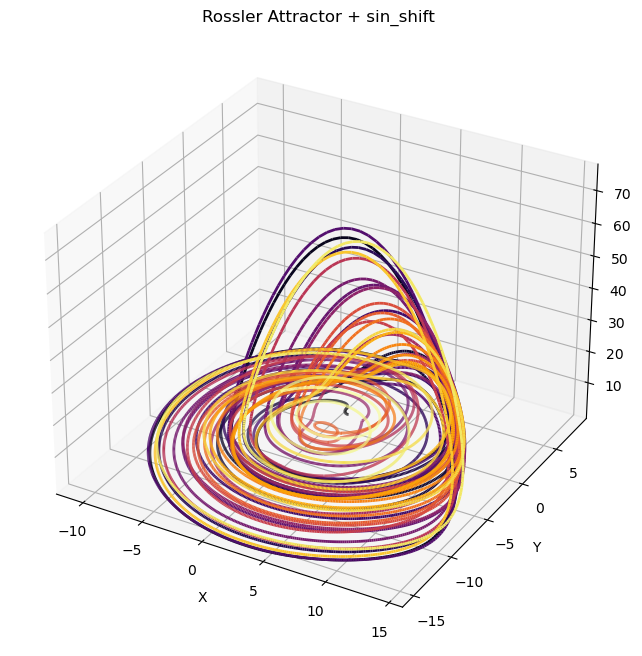

In [171]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy as np

def plot_rossler_3d_colored_efficient(data):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 時間に応じた色の変化を生成
    num_points = len(data)
    points = np.array([data['X'], data['Y'], data['Z']]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(data['Time'].min(), data['Time'].max())
    lc = Line3DCollection(segments, cmap='inferno', norm=norm)
    lc.set_array(data['Time'])
    lc.set_linewidth(2)
    ax.add_collection(lc)

    ax.set_xlim(data['X'].min(), data['X'].max())
    ax.set_ylim(data['Y'].min(), data['Y'].max())
    ax.set_zlim(data['Z'].min(), data['Z'].max())
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Rossler Attractor + sin_shift')
    plt.show()

# ここで `data_loaded` をレスラー方程式の解が含まれたデータフレームと仮定しています。
plot_rossler_3d_colored_efficient(rossler_data)


In [172]:
X_sub_names = data_loaded[['X', 'Y', 'External_Force']]
X_sub_names

,X,Y,External_Force
0,1.000000,1.000000,0.000000
1,0.980261,1.011913,0.020000
2,0.961036,1.023655,0.039999
3,0.942307,1.035231,0.059993
4,0.924058,1.046645,0.079982
...,...,...,...
24995,-5.122892,1.867768,-1.958778
24996,-5.161093,1.820033,-1.954640
24997,-5.198770,1.771823,-1.950307
24998,-5.235918,1.723143,-1.945779


In [173]:
X_sub = X_sub_names.values
X_sub

array([[ 1.        ,  1.        ,  0.        ],
       [ 0.98026135,  1.01191329,  0.02000047],
       [ 0.96103569,  1.02365542,  0.03999893],
       ...,
       [-5.19877001,  1.77182345, -1.95030708],
       [-5.23591787,  1.72314266, -1.94577886],
       [-5.27252951,  1.67399522, -1.94105604]])

In [174]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [175]:
hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [176]:
from reservoirpy.datasets import to_forecasting

train_len = 3000
test_len = 4000

x, y = to_forecasting(X_sub, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))

In [177]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [06:38<00:00,  1.99s/trial, best loss: 0.0011406822233487543]


In [178]:
def esn_chaos_prediction(X, N, iss, lr, ridge, seed, sr,  seed_timesteps, nb_generations, train_len = 2000, forecast=1,):
    
    n, m = X.shape
    
    from reservoirpy.datasets import to_forecasting

    train_len = train_len

    x, y = to_forecasting(X, forecast=forecast)
    X_train, y_train = x[:train_len], y[:train_len]
    X_test, y_test = x[train_len:], y[train_len:]

    dataset = ((X_train, y_train), (X_test, y_test))
    
    # bestから取得したハイパーパラメータを設定
    N = N
    iss = iss
    lr = lr
    ridge = ridge
    seed = seed
    sr = sr

    # データセットからトレーニングとバリデーションデータを取得
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data

    # モデルの構築
    reservoir = Reservoir(N, 
                        sr=sr, 
                        lr=lr, 
                        input_scaling=iss, 
                        seed=seed)
    readout = Ridge(ridge=ridge)
    model = reservoir >> readout
    
    warming_inputs = X_test[:seed_timesteps]

    warming_out = model.fit(X_train, y_train).run(warming_inputs, reset=True)  # warmup
    
    X_gen = np.zeros((nb_generations, m))
    y = warming_out[-1]
    for t in range(nb_generations):  # generation
        y = model(y)
        X_gen[t, :] = y
        
    X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]
    
    return X_gen, X_t, warming_out, warming_inputs

In [179]:
# 描画用のplot_generationの定義

def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

In [180]:
best

({'N': 0,
  'iss': 0.059936189081400526,
  'lr': 0.38264094967620654,
  'ridge': 1.8102732550311867e-05,
  'seed': 0,
  'sr': 0.07966435869333038},
 <hyperopt.base.Trials at 0x2871c6cd0>)

In [181]:
seed_timesteps = 1000
nb_generations = 10000

In [182]:
X_gen, X_t, warming_out, warming_inputs = esn_chaos_prediction(X_sub, 500, best[0]['iss'], best[0]['lr'], best[0]['ridge'], 1234, best[0]['sr'], seed_timesteps, nb_generations)

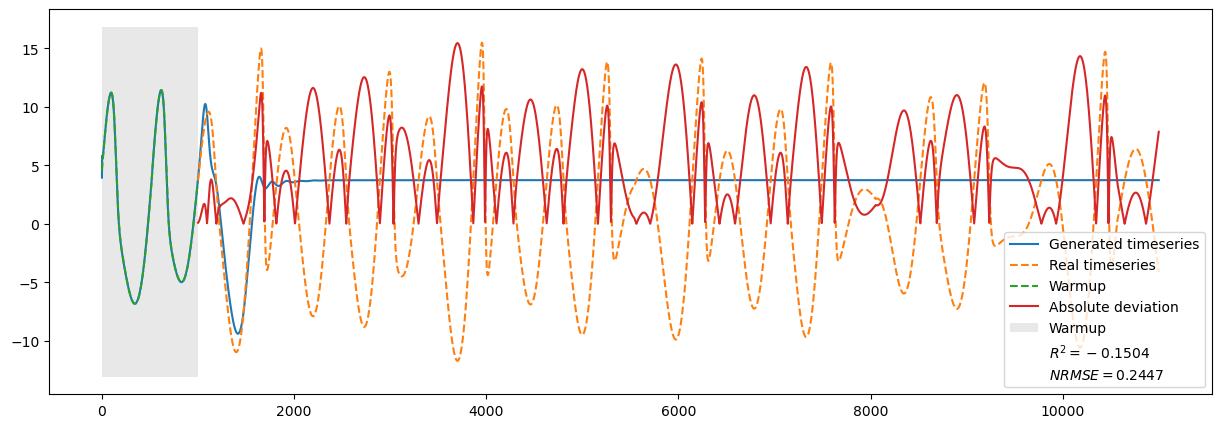

In [183]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

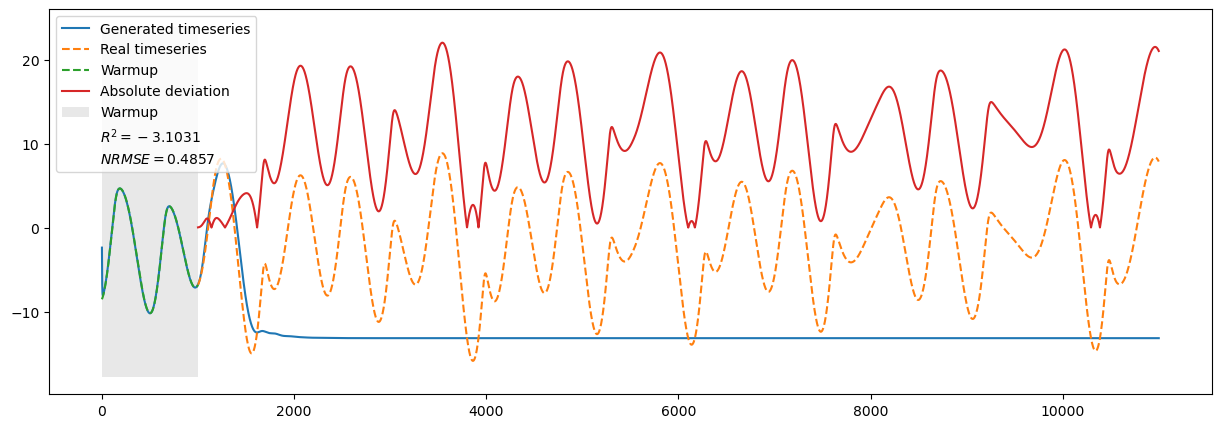

In [184]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)

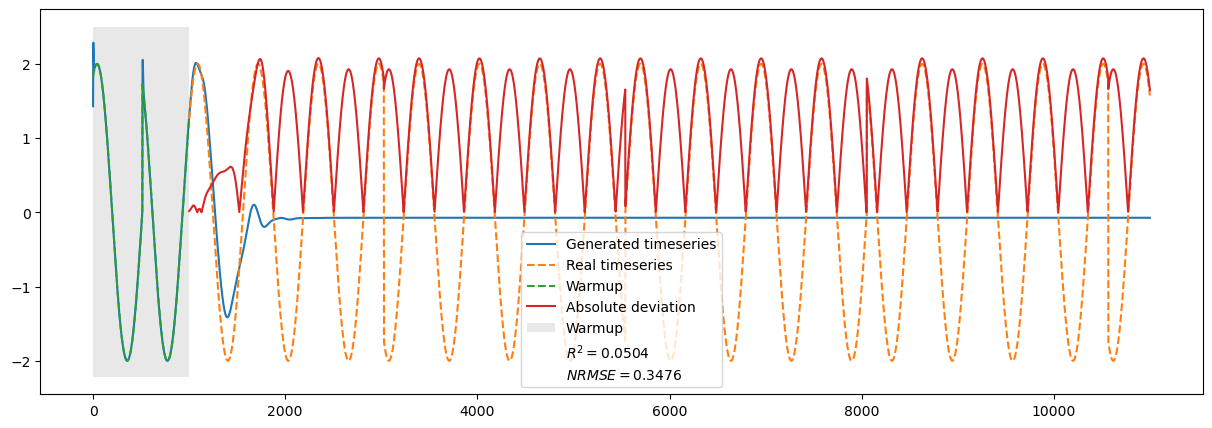

In [185]:
plot_generation(X_gen[:, 2:3], X_t[:, 2:3], nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)

In [196]:
best

({'N': 0,
  'iss': 0.059936189081400526,
  'lr': 0.38264094967620654,
  'ridge': 1.8102732550311867e-05,
  'seed': 0,
  'sr': 0.07966435869333038},
 <hyperopt.base.Trials at 0x2871c6cd0>)

In [197]:
train_len = 2000 
forecast=1 

    
n, m = X_sub.shape
    
from reservoirpy.datasets import to_forecasting

train_len = train_len

x, y = to_forecasting(X_sub, forecast=forecast)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:], y[train_len:]

dataset = ((X_train, y_train), (X_test, y_test))

# bestから取得したハイパーパラメータを設定
N = 500
iss = 0.059936189081400526
lr = 0.38264094967620654
ridge = 1.8102732550311867e-05
seed = 1234
sr = 0.07966435869333038

# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                    sr=sr, 
                    lr=lr, 
                    input_scaling=iss, 
                    seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_val)

In [198]:
seed_timesteps = seed_timesteps
nb_generations = 1500
#実際は150ステップに対応

warming_inputs = X_test[:seed_timesteps]

warming_out = model.run(warming_inputs, reset=True)  # warmup
print(f"{warming_out[-1]}:warming_out[-1]")
print(f"{X_test[seed_timesteps]}:X_test[seed_timesteps]")
#warming_outはX_test[seed_timesteps]を近似する．

[11.17689184 -0.86510984  1.67370306]:warming_out[-1]
[11.20968741 -0.86148208  1.67239046]:X_test[seed_timesteps]


In [199]:
X_gen = np.zeros((nb_generations, m))
y = warming_out[-1] 
print(y.shape) 
y = y.reshape(1, -1) 
print(y.shape) #配列の形式は(n, m)の二次元配列にする必要があるので調整した

(3,)
(1, 3)


In [200]:
for t in range(nb_generations):  
    y[:, 2:3] = X_test[seed_timesteps+t, 2:3] #外力にあたる[:, 2:3]に実測値を代入する．
    y = model(y) #ESNで1回=0.1ステップ先を予測する．
    X_gen[t, :] = y #配列に記録していく
            
X_t = X_test[seed_timesteps: nb_generations+seed_timesteps]

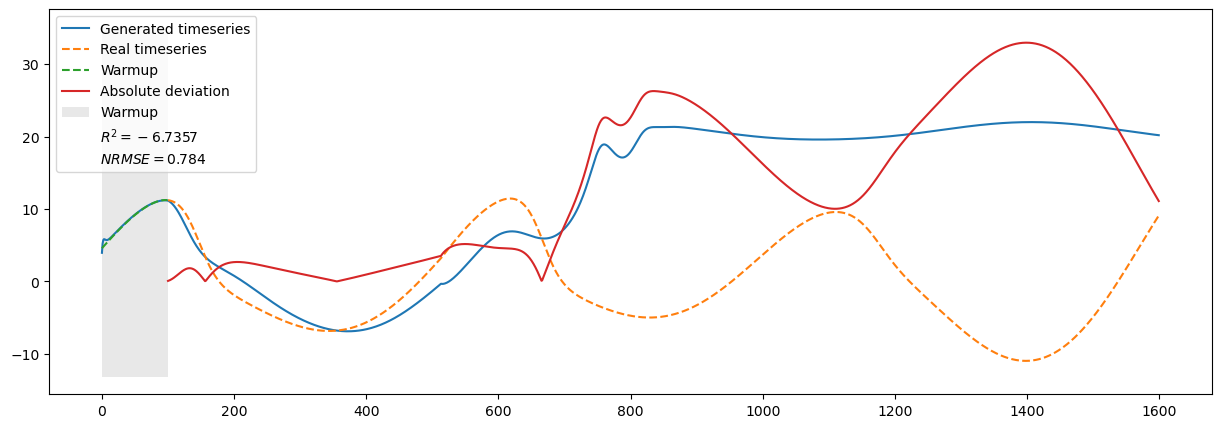

In [201]:
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

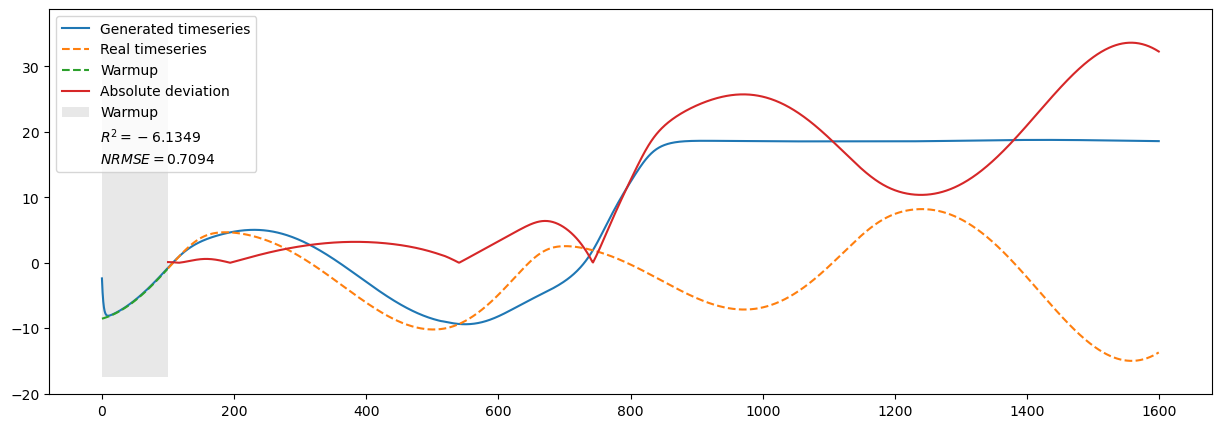

In [202]:
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)
